# Libs

In [1]:
%load_ext autotime

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
plt.style.use('bmh')

from fastquant import get_crypto_data

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

import mlflow
import mlflow.keras

import pickle
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

2022-06-30 19:21:34.267387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-30 19:21:34.267431: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


time: 3.37 s (started: 2022-06-30 19:21:32 +00:00)


# Functions

In [2]:
def data_split(df, train_perc):
    df = df[['close']]
    len_ = math.ceil(len(df) * train_perc)
    train = df[:len_]
    test = df[len_:]
    
    return train, test

def metrics(pred, test, id_):
    mae_score = mean_absolute_error(test, pred)
    mape_score = mean_absolute_percentage_error(test, pred)
    rmse_score = mean_squared_error(test, pred, squared=False)
    rq_score = r2_score(test, pred)
    
    d = {'asset': [id_], 'mae': [mae_score], 'mape': [mape_score], 'rmse': [rmse_score], 'r2': [rq_score]}
    df_results = pd.DataFrame(d)
    
    return df_results

def params(model, epochs, batch_size, optimizer, n_regs, nn):
    n_layers = 0
    n_dropout = 0
    units_layers = []
    rate_dropout = []
    
    for i in range(len(model.get_config().get('layers'))):
        if model.get_config().get('layers')[i].get('class_name') == nn:
            n_layers = n_layers + 1
            units_layers.append(model.get_config().get('layers')[i]['config'].get('units'))
        elif model.get_config().get('layers')[i].get('class_name') == 'Dropout':
            n_dropout = n_dropout + 1
            rate_dropout.append(model.get_config().get('layers')[i]['config'].get('rate'))
    
    activation = model.get_config().get('layers')[-1]['config'].get('activation')
    tp_loss_func = model.loss
    epochs = epochs
    batch_size = batch_size
    
    params_list = [n_layers, n_dropout, units_layers, rate_dropout, activation, tp_loss_func, optimizer, epochs, batch_size, n_regs]
    nm_params_list = ['n_layers', 'n_dropout', 'units_layers', 'rate_dropout', 'activation', 'tp_loss_func', 'optimizer', 'epochs', 'batch_size', 'n_regs']
    
    return params_list, nm_params_list

time: 1.63 ms (started: 2022-06-30 19:21:35 +00:00)


# Data Extract

In [3]:
present = (pd.Timestamp.today() - pd.Timedelta((1), unit='D')).strftime('%Y-%m-%d')
past = (pd.Timestamp.today() - pd.Timedelta((365*2), unit='D')).strftime('%Y-%m-%d')

time: 16.9 ms (started: 2022-06-30 19:21:35 +00:00)


In [4]:
# # Se a API da Binance estiver funcionando
# assets = pd.read_csv('data/my_assets.csv')

# assets = assets['asset'].tolist()
# fiat_currency = ['BRL']

# for i in fiat_currency:
#     if i in assets:
#         assets.remove(i)

time: 3.58 ms (started: 2022-06-30 19:21:35 +00:00)


In [5]:
# Se a API da Binance tiver morrido
assets = ['MANA', 'ADA', 'ETH', 'BTC']

time: 13.1 ms (started: 2022-06-30 19:21:35 +00:00)


In [6]:
print(assets)
print('Qtdd:', len(assets))

['MANA', 'ADA', 'ETH', 'BTC']
Qtdd: 4
time: 9.98 ms (started: 2022-06-30 19:21:35 +00:00)


In [7]:
df_raw = {}
for i in assets:
    df_raw[i] = get_crypto_data(i + '/USDT', past, present)[['close']]

df_assets = {}
for i in assets:
    df_assets[i] = {}
    df_assets[i]['train'], df_assets[i]['test'] = data_split(df_raw[i], 0.8)

time: 8.55 s (started: 2022-06-30 19:21:35 +00:00)


# Normalizer

In [8]:
transform_train = {}
transform_test = {}
scaler = {}
log_error = []
n_window = 20

for num, i in enumerate(assets):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_assets[i]['train'])
    a1 = np.array(df_assets[i]['test'])
    a0 = a0.reshape(a0.shape[0], 1)
    a1 = a1.reshape(a1.shape[0], 1)
    try:
        transform_train[i] = sc.fit_transform(a0)
        transform_test[i] = sc.fit_transform(a1)
        scaler[i] = sc
    except:
        print('Error', i)
        log_error.append(i)
        assets.remove(i)
    
del a0
del a1

print('Assets:', len(assets))
print('Errors:', len(log_error))

trainset = {}
testset = {}

for j in assets:
    trainset[j] = {}
    X_train = []
    y_train = []
    
    for i in range(n_window, len(transform_train[j])):
        X_train.append(transform_train[j][i - n_window:i, 0])
        y_train.append(transform_train[j][i, 0])
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    if len(X_train) == 0:
        del trainset[j]
        assets.remove(j)
        continue
        
    trainset[j]['X'] = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    trainset[j]['y'] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []
    
    for i in range(n_window, len(transform_test[j])):
        X_test.append(transform_test[j][i-n_window:i, 0])
        y_test.append(transform_test[j][i, 0])
        
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    testset[j]['X'] = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    testset[j]['y'] = y_test

Assets: 4
Errors: 0
time: 11.7 ms (started: 2022-06-30 19:21:44 +00:00)


In [52]:
# pickle.dump(scaler, open('scaler.pkl', 'wb'))

time: 2.71 ms (started: 2022-06-30 20:12:30 +00:00)


# ML

## LSTM

### Modeling

In [9]:
nn = 'LSTM'
optimizer = 'adam'
loss = 'mean_squared_error'
epochs = 20
batch_size = 64 

regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# regressor.add(LSTM(units=50))
# regressor.add(Dropout(0.2))
regressor.add(LSTM(units=25, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))
regressor.compile(optimizer=optimizer, loss=loss)

cont = 1
for i in assets:
    print(cont, '/', str(len(assets)))
    regressor.fit(trainset[i]['X'], trainset[i]['y'], epochs=epochs, batch_size=batch_size)
    cont = cont + 1
    clear_output(wait=True)

time: 18.6 s (started: 2022-06-30 19:21:44 +00:00)


### Metrics/Params

4/4 [==============================] - 0s 6ms/step


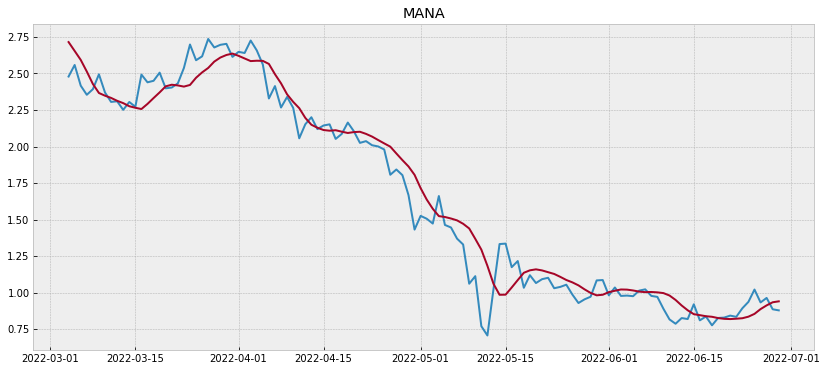

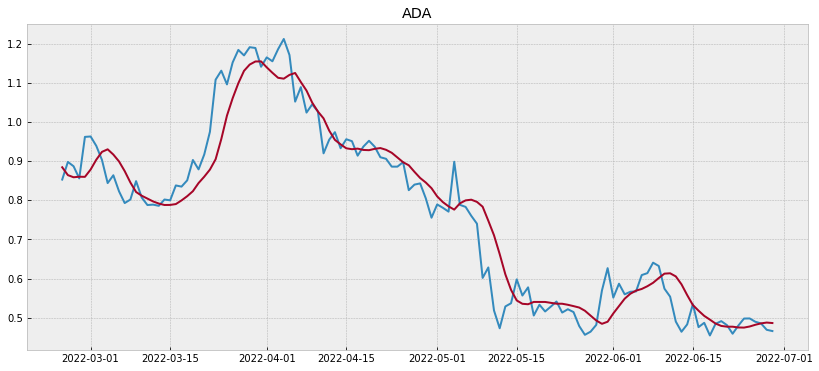

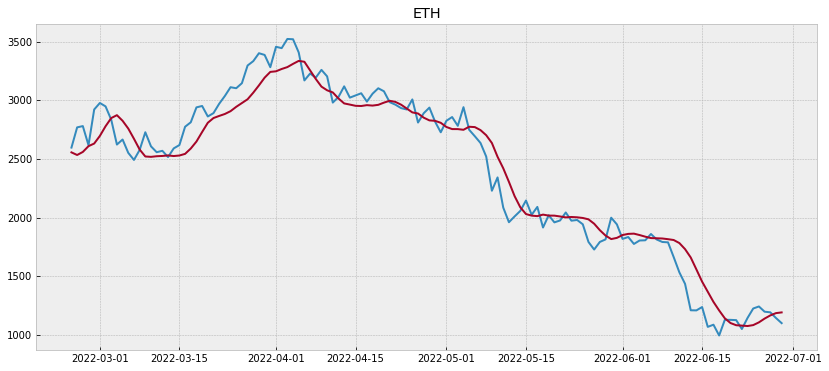

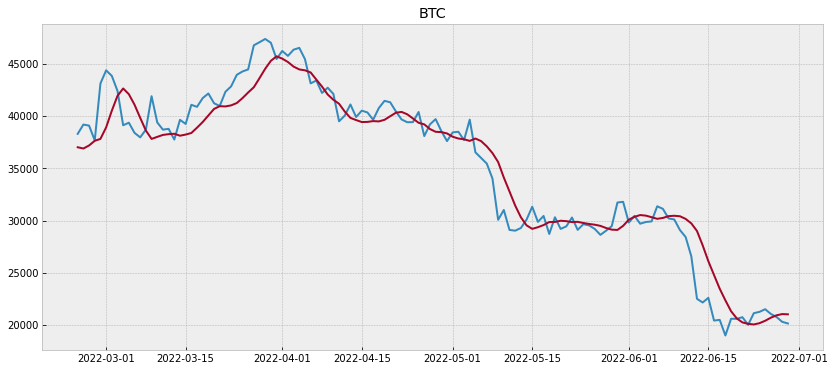

time: 1.44 s (started: 2022-06-30 19:22:03 +00:00)


In [10]:
pred_result = {}
res_metrics = pd.DataFrame()

for i in assets:
    if len(testset[i]['y']) > 0:
        y_true = scaler[i].inverse_transform(testset[i]['y'].reshape(-1,1))
        y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]['X']))
        
        x_axis = df_assets[i]['test'][-len(y_true):].index
        plt.figure(figsize=(14,6))
        plt.title(i)
        plt.plot(x_axis, y_true)
        plt.plot(x_axis, y_pred)
        
        pred_result[i] = {}
        pred_result[i]['true'] = y_true
        pred_result[i]['pred'] = y_pred
        
        res_metrics = res_metrics.append(metrics(y_pred, y_true, i))
#         res_metrics.to_csv('')

res_metrics_mean = res_metrics.iloc[:,1:].mean().to_frame().T
metrics_mean_dict = res_metrics_mean.T.to_dict()[0]
params_list, nm_params_list = params(regressor, epochs, batch_size, optimizer, n_window, nn)

In [11]:
res_metrics

,asset,mae,mape,rmse,r2
0,MANA,0.098066,0.072553,0.137009,0.959915
0,ADA,0.044059,0.061817,0.061280,0.926733
0,ETH,121.444070,0.057093,156.343253,0.951328
0,BTC,1465.582545,0.044524,1990.359449,0.935455


time: 9.86 ms (started: 2022-06-30 19:22:04 +00:00)


In [12]:
res_metrics_mean

,mae,mape,rmse,r2
0,396.792185,0.058997,536.725248,0.943358


time: 12.5 ms (started: 2022-06-30 19:22:04 +00:00)


### Forecast

In [41]:
num_pred = 20

time: 335 µs (started: 2022-06-30 19:31:13 +00:00)


In [14]:
# # Eu mesmo fiz
# pred = []
# tempset = testset['BTC']['X'].copy()

# for i in range(num_pred):
#     pred.append(regressor.predict(tempset[-1].reshape(1,tempset.shape[1],1))[0][0])

#     tempset = tempset.reshape(tempset.shape[0], tempset.shape[1])
#     tempset = pd.DataFrame(tempset)
#     tempset = tempset.append(tempset[-1:].shift(-1, axis=1).fillna(pred[-1]), ignore_index=True)

#     tempset = np.array(tempset).reshape(tempset.shape[0], tempset.shape[1], 1)
    
# tempset = scaler['BTC'].inverse_transform(tempset[-1])

time: 6.29 ms (started: 2022-06-30 19:22:04 +00:00)


In [28]:
def predict(num_pred, model, n_window, asset):
    pred_list = asset_forecast[-n_window:]
    
    for _ in range(num_pred):
        x = pred_list[-n_window:]
        x = scaler[asset].transform(x.reshape(-1, 1))
        x = x.reshape((1, n_window, 1))
        out = scaler[asset].inverse_transform(model.predict(x, verbose=0))[0][0]
        pred_list = np.append(pred_list, out)
    pred_list = pred_list[n_window-1:]
    
    return pred_list

def predict_dates(num_pred, last_date):
    return pd.date_range(last_date, periods=num_pred+1).to_list()

time: 821 µs (started: 2022-06-30 19:26:31 +00:00)


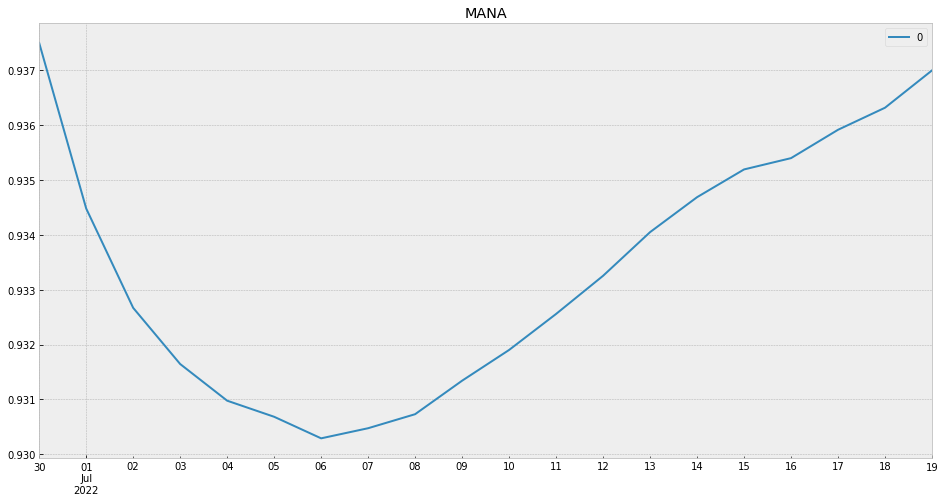

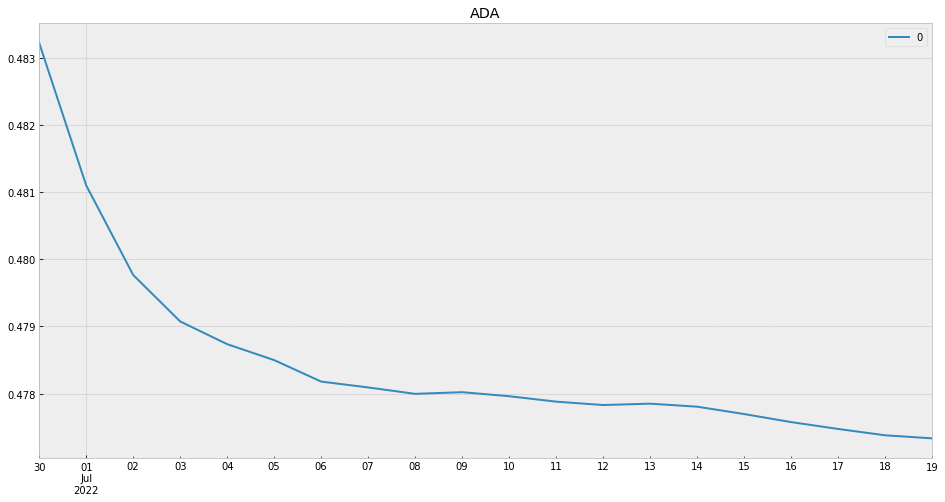

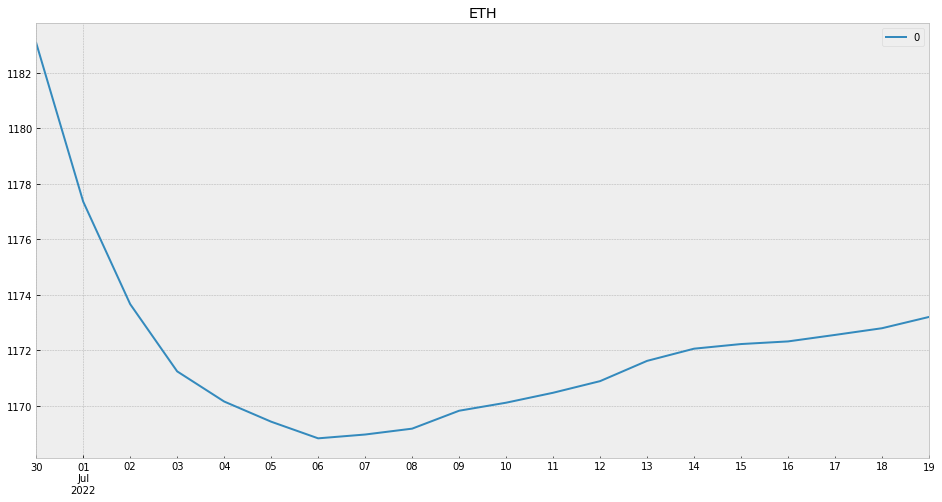

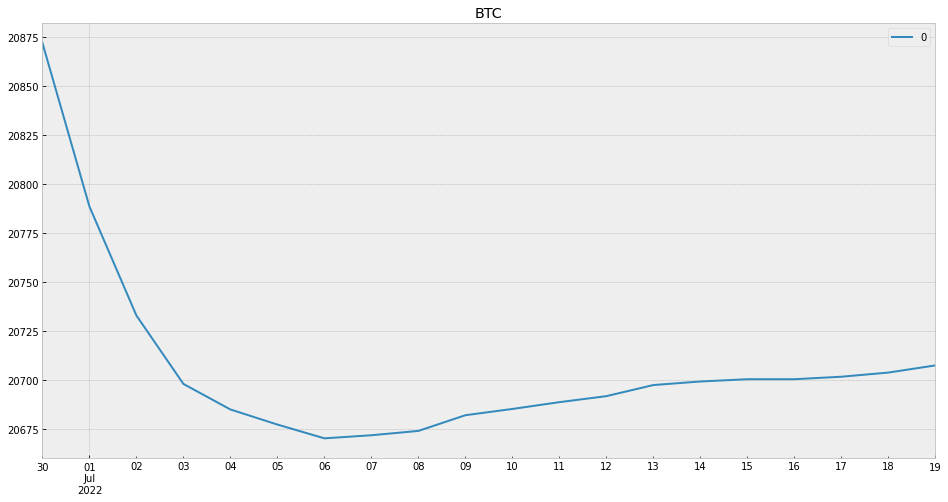

time: 3.41 s (started: 2022-06-30 19:31:15 +00:00)


In [42]:
for asset in assets:
    asset_forecast = df_raw[asset]['close'].values.reshape((-1,1))
    last_date = df_raw[asset].index[-1]
    forecast = predict(num_pred, regressor, n_window, asset)
    forecast_dates = predict_dates(num_pred, last_date)
    # pd.DataFrame(forecast, index=forecast_dates).plot.line(figsize=(16,8), title=asset)  # pega desde a primeira predicao
    pd.DataFrame(forecast[1:], index=forecast_dates[1:]).plot.line(figsize=(16,8), title=asset)  # pega somente as predicoes futuras

### MLFlow Tracking

In [17]:
# mlflow.set_tracking_uri('http://0.0.0.0:5000')
# mlflow.set_experiment(experiment_name='crypto')
# artifact_path = 'model'

# with mlflow.start_run(run_name=nn, nested=False):

#     for i, j in zip(nm_params_list, params_list):
#         mlflow.log_param(i, j)
    
#     mlflow.log_metrics(metrics_mean_dict)
#     mlflow.keras.log_model(regressor, artifact_path=artifact_path)
#     model_uri = mlflow.get_artifact_uri(artifact_path)
#     print('Model artifact logged to:', model_uri)
    
#     mlflow.end_run()

time: 497 µs (started: 2022-06-30 19:22:06 +00:00)


### Save Model Manual

In [18]:
# regressor.save('model_test')
# model_loaded = load_model('model_test')

time: 11 ms (started: 2022-06-30 19:22:06 +00:00)
